# Jina Embeddings v3

Extra datacleaning

### Imports

In [1]:
# # Install necessary libraries if not already installed
# !pip install --upgrade torch torchvision
# !pip install flash-attn --no-build-isolation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from pathlib import Path
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from bs4 import BeautifulSoup
import random
import umap
import re
import pandas as pd
import matplotlib.pyplot as plt
import re


## Step 2: Data cleaning 



#### Load data

In [21]:
df_total_NOS= pd.read_csv(r"E:\Nieuw dataset\Dutch news articles 2015-2025 NOS.nl\articles_cleaned.csv")
df_total_NOS.head()

,published_time,title,description,content,url,channel
0,2015/01/01,Euro nu ook in Litouwen,Vanaf vandaag betalen ze in Litouwen met de eu...,Euro nu ook in Litouwen In Litouwen wordt vana...,https://nos.nl/artikel/2011341-euro-nu-ook-in-...,nos
1,2015/01/01,Start 2015 vol vreugde maar ook met gewonden e...,Nederland is met oliebollen en vuurwerk het ni...,Start 2015 vol vreugde maar ook met gewonden e...,https://nos.nl/artikel/2011343-start-2015-vol-...,nos
2,2015/01/01,Letland nieuwe voorzitter van de Europese Unie,Vanaf vandaag neemt Letland het stokje over va...,Letland nieuwe voorzitter van de Europese Unie...,https://nos.nl/artikel/2011346-letland-nieuwe-...,nos
3,2015/01/01,Noord-Korea wil praten met Zuid-Korea,De Noord-Koreaanse leider Kim Jong-un zei in z...,Noord-Korea wil praten met Zuid-Korea De Noord...,https://nos.nl/artikel/2011348-noord-korea-wil...,nos
4,2015/01/01,"Feest in Londen, Parijs en Berlijn",In Londen en Berlijn waren muziekfestivals. Pa...,"Feest in Londen, Parijs en Berlijn In Europa i...",https://nos.nl/artikel/2011351-feest-in-londen...,nos


Woorden en carracters tellen voor en na de cleaning

voor embedding cleaning 

In [23]:
# Combine 'title', 'description', and 'content' into 'combined_text'
df_total_NOS['combined_text'] = df_total_NOS['title'].fillna('') + ". " + df_total_NOS['description'].fillna('') + ". " + df_total_NOS['content'].fillna('')

def calculate_csv_stats(df_total_NOS):
    """
    Calculate and print the total number of characters in 'combined_text' 
    and the size of the DataFrame in megabytes.

    Args:
        df (pd.DataFrame): The DataFrame containing the 'combined_text' column.

    Returns:
        tuple: Total characters and CSV size in megabytes.
    """
    # Bereken het totale aantal karakters in 'combined_text'
    total_characters = df_total_NOS['combined_text'].str.len().sum()
    print(f"Totaal aantal karakters in 'combined_text': {total_characters}")

    # Bereken de grootte van de CSV in megabytes
    csv_size_mb = df_total_NOS.memory_usage(deep=True).sum() / (1024 * 1024)
    print(f"Grootte van de CSV: {csv_size_mb:.2f} MB")
    
    return total_characters, csv_size_mb

# Roep de functie aan
total_characters, csv_size_mb = calculate_csv_stats(df_total_NOS)

Totaal aantal karakters in 'combined_text': 768792152
Grootte van de CSV: 2260.17 MB


Text cleaning

* evt nog stop woorden verwijderen zoals ik etc 

In [24]:


# Define the text cleaning function
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[\/\-']", ' ', text)
    text = re.sub(r"&", ' and ', text)
    text = re.sub(r"[^a-zA-Z0-9\s]", '', text)
    text = re.sub(r"\s+", ' ', text).strip()
    return text

# Apply the cleaning function to the 'combined_text' column
df_total_NOS['combined_text'] = df_total_NOS['combined_text'].apply(clean_text)

total_characters, csv_size_mb = calculate_csv_stats(df_total_NOS)

Totaal aantal karakters in 'combined_text': 749908840
Grootte van de CSV: 1898.18 MB


oke dit heeft niet veel verschil gemaakt, wil nu keyword search doen voordat ik ga embedden

> Import en keyword-definitie

In [25]:


# Definieer de lijst van EV-gerelateerde keywords
ev_keywords = [
    "elektrische auto", "elektrische voertuigen", "elektrisch rijden", "stekkerauto", "emissievrij",
    "zero emission", "elektrisch vervoer", "battery electric vehicle", "BEV", "EV", "EV-markt",
    "laadpaal", "laadinfrastructuur", "laadstation", "snelladen", "laadtijd",
    "laadnetwerk", "opladen", "elektriciteitsnet", "netcongestie",
    "batterij", "accu", "actieradius", "solid state batterij", "energieopslag", "accutechnologie",
    "Tesla", "BYD", "Volkswagen ID", "Renault Zoe", "Hyundai Ioniq", "Kia EV",
    "Nissan Leaf", "Polestar", "BMW i", "Ford Mustang Mach-E", "Audi e-tron",
    "subsidie elektrische auto", "aanschafsubsidie", "bijtelling",
    "fiscale stimulering", "milieu-investeringsaftrek", "overheidsbeleid", "klimaatmaatregelen",
    "duurzame mobiliteit", "klimaatbeleid", "CO2-uitstoot", "groene transitie",
    "verduurzaming vervoer", "energietransitie", "schoner verkeer",
    "tweedehands elektrische auto", "EV import", "EV export", "restwaarde EV",
    "autoverkoop EV", "EV occasion", "elektrisch leasen", "Subsidieregeling Elektrische Personenauto's Particulieren"
]

# Maak regex patroon: \b staat voor woordgrenzen
ev_pattern = r'\b(?:' + '|'.join(re.escape(kw) for kw in ev_keywords) + r')\b'


 >Filteren van EV-artikelen

In [26]:
# Filter de DataFrame met behulp van regex (één of meer keywords)
ev_mask = df_total_NOS['combined_text'].str.contains(ev_pattern, case=False, na=False, regex=True)
df_ev = df_total_NOS[ev_mask].copy()


>vanaf hier overgegaan van df_total_NOS naar df_ev

In [ ]:
# Basisinformatie over EV-artikelen
print(f"Totaal aantal karakters: {df_ev['combined_text'].str.len().sum()}")
print(f"Grootte DataFrame: {df_ev.memory_usage(deep=True).sum() / (1024 * 1024):.2f} MB")

# Artikelen per kanaal
print("\nAantal artikelen per kanaal:")
print(df_ev['channel'].value_counts())

# Artikelen per maand
df_ev['year_month'] = pd.to_datetime(df_ev['published_time']).dt.to_period('M')
articles_per_month = df_ev['year_month'].value_counts().sort_index()
print("\nAantal artikelen per maand:")
print(articles_per_month)

# Ontbrekende maanden
all_months = pd.period_range(start=articles_per_month.index.min(), end=articles_per_month.index.max(), freq='M')
missing_months = all_months.difference(articles_per_month.index)
print("\nOntbrekende maanden (geen artikelen):")
print(missing_months)


display(df_ev)


Totaal aantal karakters: 17197163
Grootte DataFrame: 46.72 MB

Aantal artikelen per kanaal:
channel
nos          3301
nieuwsuur     315
Name: count, dtype: int64

Aantal artikelen per maand:
year_month
2015-01    12
2015-02    12
2015-03    27
2015-04    14
2015-05    15
           ..
2024-09    44
2024-10    52
2024-11    51
2024-12    41
2025-01    49
Freq: M, Name: count, Length: 121, dtype: int64

Ontbrekende maanden (geen artikelen):
PeriodIndex([], dtype='period[M]')


,published_time,title,description,content,url,channel,combined_text,year_month
7,2015/01/01,Verkoop nieuwe auto's stevent af op laagterecord,Nederlanders kochten in 2014 opnieuw minder au...,Verkoop nieuwe auto's stevent af op laagtereco...,https://nos.nl/artikel/2011357-verkoop-nieuwe-...,nos,verkoop nieuwe auto s stevent af op laagtereco...,2015-01
74,2015/01/02,De stroom 02/01,De stroom van NOS op 3,De stroom 02/01 'Vermiste Amerikaan dood gevon...,https://nos.nl/op3/liveblog/2011449-de-stroom-...,nos,de stroom 02 01 de stroom van nos op 3 de stro...,2015-01
305,2015/01/05,Wind en hitte bedreigen bosbrandgebied Australië,De vuurzee heeft meer dan twintig huizen verwo...,Wind en hitte bedreigen bosbrandgebied Austral...,https://nos.nl/artikel/2011782-wind-en-hitte-b...,nos,wind en hitte bedreigen bosbrandgebied austral...,2015-01
867,2015/01/10,Hoe gegijzelden buiten schot bleven in Parijs,Noemi belde vanuit de koelruimte in de joodse ...,Hoe gegijzelden buiten schot bleven in Parijs ...,https://nos.nl/artikel/2012612-hoe-gegijzelden...,nos,hoe gegijzelden buiten schot bleven in parijs ...,2015-01
1075,2015/01/12,Stroomstoring Rotterdam automatisch opgelost,In Rotterdam zaten gisteren zo'n 600 huizen en...,Stroomstoring Rotterdam automatisch opgelost V...,https://nos.nl/artikel/2012942-stroomstoring-r...,nos,stroomstoring rotterdam automatisch opgelost i...,2015-01
...,...,...,...,...,...,...,...,...
291029,2025/01/23,Den Haag ontvangt vicepremier China op het hoo...,Ding Xuexiang zit in de top van het Chinese re...,Den Haag ontvangt vicepremier China op het hoo...,https://nos.nl/l/2552983,nos,den haag ontvangt vicepremier china op het hoo...,2025-01
291090,2025/01/24,"Dode in Ierland na Éowyn, zwaarste storm sinds...","Er zijn geen ongevallen gemeld, maar de storm ...","Dode in Ierland na Éowyn, zwaarste storm sinds...",https://nos.nl/l/2553090,nos,dode in ierland na owyn zwaarste storm sinds 1...,2025-01
291229,2025/01/27,"Regionale industrie krijgt geen stroom, maar b...",Driekwart van de verduurzamingsplannen van de ...,"Regionale industrie krijgt geen stroom, maar b...",https://nos.nl/l/2553436,nos,regionale industrie krijgt geen stroom maar be...,2025-01
291267,2025/01/27,"Oost-Congo al langer toneel van strijd, vooral...",Rebellengroep M23 claimt de belangrijke stad G...,"Oost-Congo al langer toneel van strijd, vooral...",https://nos.nl/l/2553522,nos,oost congo al langer toneel van strijd vooral ...,2025-01


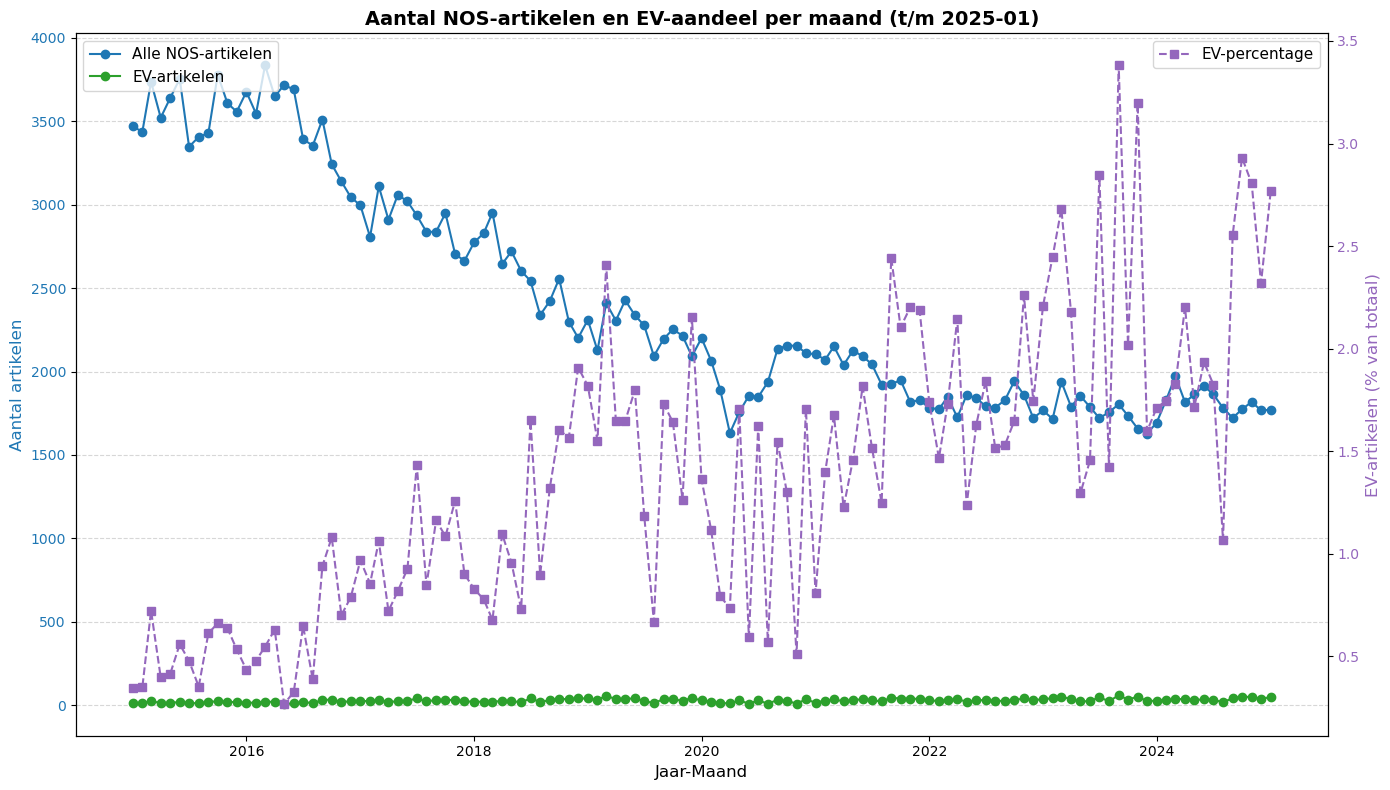

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Zorg dat published_time in datetime staat
df_total_NOS['published_time'] = pd.to_datetime(df_total_NOS['published_time'], errors='coerce')
df_ev['published_time'] = pd.to_datetime(df_ev['published_time'], errors='coerce')

# Voeg 'year_month' toe
df_total_NOS['year_month'] = df_total_NOS['published_time'].dt.to_period('M')
df_ev['year_month'] = df_ev['published_time'].dt.to_period('M')

# Filter tot en met 2025-01
df_total_NOS = df_total_NOS[df_total_NOS['year_month'] <= pd.Period('2025-01', freq='M')]
df_ev = df_ev[df_ev['year_month'] <= pd.Period('2025-01', freq='M')]

# Tellingen per maand
total_articles_per_month = df_total_NOS['year_month'].value_counts().sort_index()
ev_articles_per_month = df_ev['year_month'].value_counts().sort_index()

# Synchroniseer maanden
all_months = pd.period_range(start=min(total_articles_per_month.index.min(), ev_articles_per_month.index.min()),
                             end='2025-01', freq='M')
total_articles_per_month = total_articles_per_month.reindex(all_months, fill_value=0)
ev_articles_per_month = ev_articles_per_month.reindex(all_months, fill_value=0)

# Bereken percentage EV
ev_percentage_per_month = (ev_articles_per_month / total_articles_per_month.replace(0, np.nan)) * 100

# Zet X-as om naar timestamps
x_vals = all_months.to_timestamp()

# Plotten
fig, ax1 = plt.subplots(figsize=(14, 8))

# Linker Y-as: aantal artikelen
color1 = 'tab:blue'
ax1.set_xlabel("Jaar-Maand", fontsize=12)
ax1.set_ylabel("Aantal artikelen", color=color1, fontsize=12)
ax1.plot(x_vals, total_articles_per_month, label="Alle NOS-artikelen", color=color1, marker='o')
ax1.plot(x_vals, ev_articles_per_month, label="EV-artikelen", color='tab:green', marker='o')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.legend(loc="upper left", fontsize=11)
ax1.grid(axis='y', linestyle='--', alpha=0.5)

# Rechter Y-as: percentage EV
ax2 = ax1.twinx()
color2 = 'tab:purple'
ax2.set_ylabel("EV-artikelen (% van totaal)", color=color2, fontsize=12)
ax2.plot(x_vals, ev_percentage_per_month, color=color2, marker='s', linestyle='--', label="EV-percentage")
ax2.tick_params(axis='y', labelcolor=color2)
ax2.legend(loc="upper right", fontsize=11)

# Titel & X-as
plt.title("Aantal NOS-artikelen en EV-aandeel per maand (t/m 2025-01)", fontsize=14, fontweight="bold")
plt.xticks(rotation=90, fontsize=8)
plt.tight_layout()
plt.show()




In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def prepare_monthly_counts(df, date_col='published_time', end_period='2025-01'):
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    df['year_month'] = df[date_col].dt.to_period('M')
    return df[df['year_month'] <= pd.Period(end_period, freq='M')]

def plot_monthly_stats(df_total, df_ev):
    # Tel per maand
    total = df_total['year_month'].value_counts().sort_index()
    ev = df_ev['year_month'].value_counts().sort_index()

    # Synchroniseer maanden
    all_months = pd.period_range(start=min(total.index.min(), ev.index.min()), end='2025-01', freq='M')
    total = total.reindex(all_months, fill_value=0)
    ev = ev.reindex(all_months, fill_value=0)
    ev_pct = (ev / total.replace(0, np.nan)) * 100
    x = all_months.to_timestamp()

    # Plot met dubbele Y-as
    fig, ax1 = plt.subplots(figsize=(14, 8))
    ax1.set_xlabel("Jaar-Maand", fontsize=12)
    ax1.set_ylabel("Aantal artikelen", color='tab:blue', fontsize=12)
    ax1.plot(x, total, label="Alle NOS-artikelen", color='tab:blue', marker='o')
    ax1.plot(x, ev, label="EV-artikelen", color='tab:green', marker='o')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.legend(loc="upper left", fontsize=11)
    ax1.grid(axis='y', linestyle='--', alpha=0.5)

    ax2 = ax1.twinx()
    ax2.set_ylabel("EV-artikelen (% van totaal)", color='tab:purple', fontsize=12)
    ax2.plot(x, ev_pct, color='tab:purple', marker='s', linestyle='--', label="EV-percentage")
    ax2.tick_params(axis='y', labelcolor='tab:purple')
    ax2.legend(loc="upper right", fontsize=11)

    plt.title("Aantal NOS-artikelen en EV-aandeel per maand (t/m 2025-01)", fontsize=14, fontweight="bold")
    plt.xticks(rotation=90, fontsize=8)
    plt.tight_layout()
    plt.show()

def plot_ev_trend(df_ev):
    counts = df_ev['year_month'].value_counts().sort_index()
    x = counts.index.to_timestamp()
    y = counts.values
    x_nums = np.arange(len(x))
    trend = np.poly1d(np.polyfit(x_nums, y, 1))

    plt.figure(figsize=(14, 8))
    plt.plot(x, y, label="EV-artikelen per maand", marker='o', color='green')
    plt.plot(x, trend(x_nums), label="Lineaire trend", linestyle='--', color='black')
    plt.title("Aantal EV-gerelateerde artikelen per maand (t/m 2025-01)", fontsize=14, fontweight="bold")
    plt.xlabel("Jaar-Maand", fontsize=12)
    plt.ylabel("Aantal artikelen", fontsize=12)
    plt.xticks(rotation=90, fontsize=8)
    plt.grid(axis='y', linestyle="--", alpha=0.5)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

# === Uitvoeren ===
df_total_NOS = prepare_monthly_counts(df_total_NOS)
df_ev = prepare_monthly_counts(df_ev)







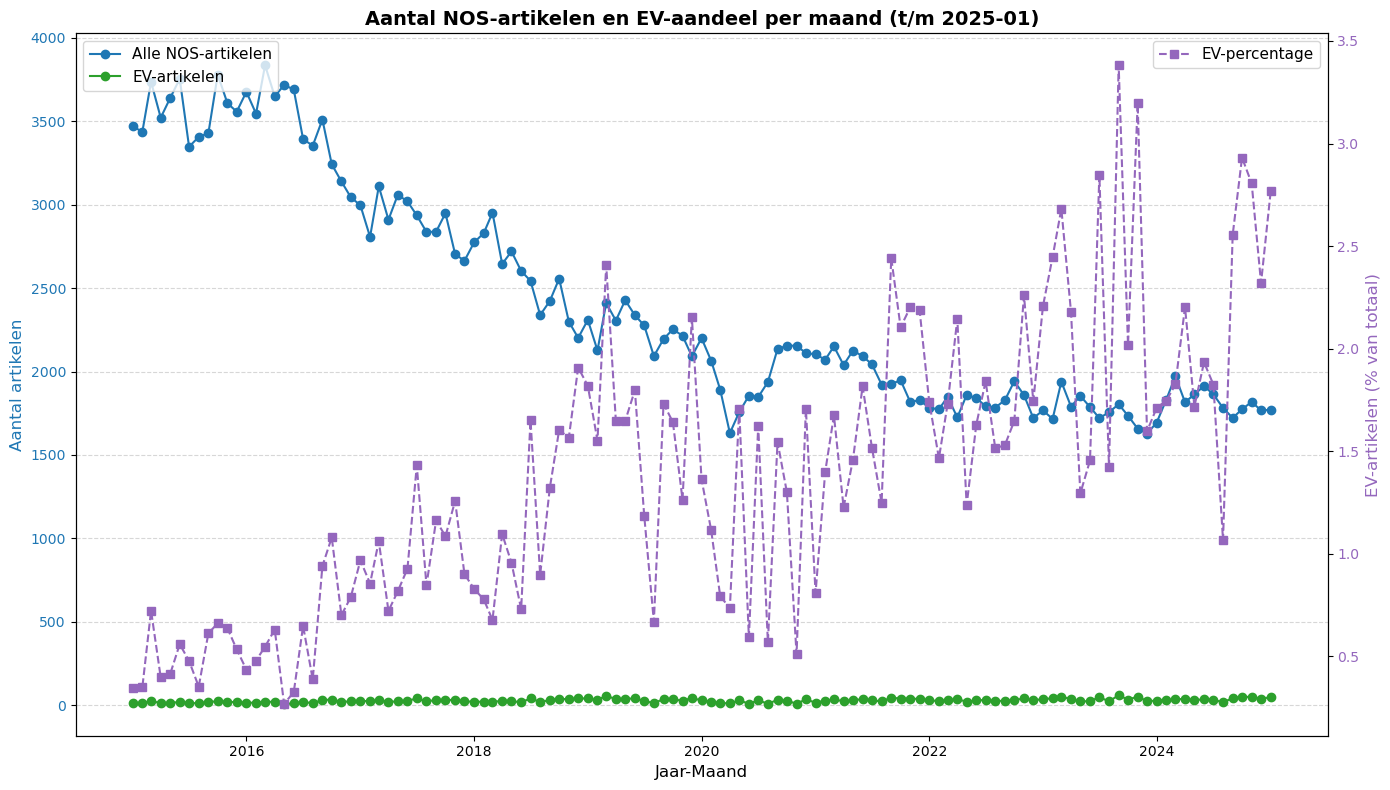

In [40]:
plot_monthly_stats(df_total_NOS, df_ev)

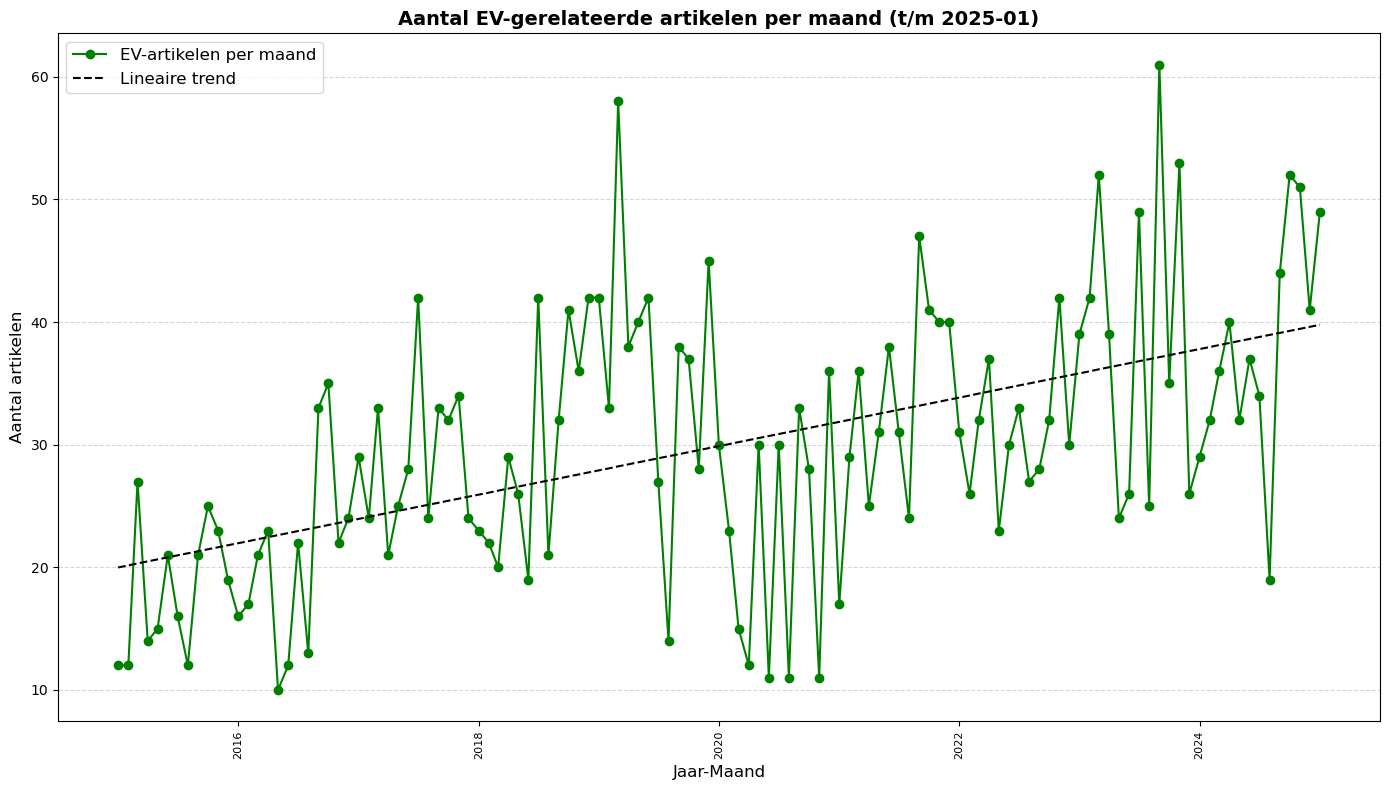

In [38]:
plot_ev_trend(df_ev)

In [41]:
output_path = r"E:\Nieuw dataset\EV_related_articles1.csv"
df_ev.to_csv(output_path, index=False, encoding='utf-8')
print(f"EV-related articles exported to: {output_path}")


EV-related articles exported to: E:\Nieuw dataset\EV_related_articles1.csv


In [46]:

# Display 10 random titles and URLs from the EV-related articles DataFrame
random_articles = df_ev.sample(20, random_state=42)[['title', 'url']]

# Print the titles, URLs, and matching keywords
for index, row in random_articles.iterrows():
    title = row['title']
    url = row['url']
    # Access 'combined_text' from the original df_ev DataFrame using the index
    full_text = df_ev.loc[index, 'combined_text']
    
    matching_keywords = [kw for kw in ev_keywords if kw.lower() in full_text.lower()]
    
    print(f"Title: {title}")
    print(f"URL: {url}")
    print(f"Matching Keywords: {', '.join(matching_keywords) if matching_keywords else 'None'}\n")

random_articles = df_ev.sample(10, random_state=42)[['title', 'url']]

# Print the titles, URLs, and matching keywords
for index, row in random_articles.iterrows():
    title = row['title']
    url = row['url']
    matching_keywords = [keyword for keyword in ev_keywords if keyword.lower() in title.lower()]
    
    print(f"Title: {title}")
    print(f"URL: {url}")
    print(f"Matching Keywords: {', '.join(matching_keywords) if matching_keywords else 'None'}\n")

Title: Veel meer elektrische auto's aan boord van brandend schip dan gedacht: 498
URL: https://nos.nl/artikel/2484547-veel-meer-elektrische-auto-s-aan-boord-van-brandend-schip-dan-gedacht-498
Matching Keywords: elektrische auto, EV, accu

Title: Boeren vs. burgers, mobiliteit en woningnood: provinciale politici in gesprek 
URL: https://nos.nl/artikel/2275549-boeren-vs-burgers-mobiliteit-en-woningnood-provinciale-politici-in-gesprek
Matching Keywords: EV, energietransitie

Title: Raster onder stroom moet grutto's Groningen beschermen tegen zwemmende vossen
URL: https://nos.nl/artikel/2471994-raster-onder-stroom-moet-grutto-s-groningen-beschermen-tegen-zwemmende-vossen
Matching Keywords: EV, accu

Title: Huizen, auto's, industrie: 'Forse extra inspanning nodig voor Nederlands klimaatbeleid'
URL: https://nos.nl/artikel/2399019-huizen-auto-s-industrie-forse-extra-inspanning-nodig-voor-nederlands-klimaatbeleid
Matching Keywords: elektrische auto, EV, klimaatbeleid

Title: Campagneblog: Plou

In [50]:
# Filter articles in df_ev that do not contain any of the keywords in ev_keywords
def find_articles_without_keywords(df_ev, ev_keywords):
    """
    Find articles in df_ev that do not contain any of the specified keywords.

    Args:
        df_ev (pd.DataFrame): DataFrame containing articles.
        ev_keywords (list): List of keywords to check.

    Returns:
        pd.DataFrame: DataFrame of articles without matching keywords.
    """
    no_match_mask = ~df_ev['combined_text'].str.contains(
        '|'.join(map(re.escape, ev_keywords)), case=False, na=False
    )
    return df_ev[no_match_mask]

# Call the function
articles_without_keywords = find_articles_without_keywords(df_ev, ev_keywords)

# Print the count and display the articles
print(f"Number of articles without matching keywords: {len(articles_without_keywords)}")
display(articles_without_keywords[['title', 'url']])



Number of articles without matching keywords: 0


,title,url


## Google Collab code 

In [ ]:

# import pandas as pd

# #Load the filtered EV-related articles CSV into a new DataFrame
# df_ev = pd.read_csv("/content/EV_related_articles.csv") 


# #Preview van de kolommen
# print(df_ev.columns) # Changed df to df_ev
# df_ev.head() # Changed df to df_ev


# from sentence_transformers import SentenceTransformer

# #Laad het model
# model = SentenceTransformer("jinaai/jina-embeddings-v3", trust_remote_code=True)



# #Combineer de kolommen ZONDER af te kappen op 512 tekens
# teksten = (
#     df_ev['title'].fillna('') + ". " +
#     df_ev['description'].fillna('') + ". " +
#     df_ev['content'].fillna('')
# ).astype(str).tolist()

# #Genereer de embeddings (mogelijk zwaarder/slomer)
# embeddings = model.encode(
#     teksten,
#     task="separation",
#     prompt_name="separation",
#     show_progress_bar=True,
#     batch_size=2  # Lager zetten i.v.m. lange input
# )



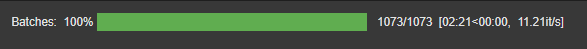

In [ ]:
# import numpy as np


# np.save("jina_embeddings.npy", embeddings)
# from google.colab import files
# files.download("jina_embeddings.npy")


In [ ]:
# n_clusters = 10
# kmeans = KMeans(n_clusters=n_clusters, random_state=42)
# df_sample['cluster'] = kmeans.fit_predict(embeddings)
# df_sample[['content', 'cluster']].head(10)

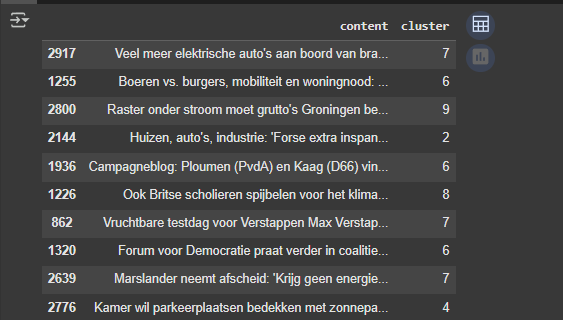

In [ ]:

# # Reload the SentenceTransformer model
# model = SentenceTransformer("jinaai/jina-embeddings-v3", trust_remote_code=True)

# #  1. Meerdere zoekzinnen definiëren (specifieker & breder)
# zoekzinnen = [
#     "Artikel over elektrische auto's of laadpalen.",
#     "Nieuws over accutechnologie, stekkervoertuigen of EV-beleid.",
#     "EV, elektrische auto, laadpaal, Tesla, batterij — dit artikel gaat hierover."
# ]

# #  2. Encode alle zoekzinnen
# query_embeddings = model.encode( # Now using the correct 'model' 
#     zoekzinnen,
#     prompt_name="retrieval.query",
#     normalize_embeddings=True
# )

# #  3. Normaliseer artikel-embeddings
# artikel_embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)

# #  4. Bereken cosine similarity tussen alle queries en artikelen
# scores_matrix = cosine_similarity(query_embeddings, artikel_embeddings)

# #  5. Neem de hoogste score per artikel
# max_scores = scores_matrix.max(axis=0)

# #  6. Voeg toe aan DataFrame
# df_sample['ev_score'] = max_scores
# df_sample['is_ev_semantisch'] = df_sample['ev_score'] > 0.5  # ↩ experimenteer met deze drempel

# #  7. (Optioneel) ook keyword-based fallback
# df_sample['is_ev_keyword'] = df_sample['content'].str.contains(
#     "elektrische auto|laadpaal|accu|EV|Tesla|opladen|emissievrij", case=False, na=False
# )

# #  8. Combineer
# df_sample['is_ev_final'] = df_sample['is_ev_semantisch'] | df_sample['is_ev_keyword']

# # 9. Resultaat inspecteren
# df_sample[['content', 'ev_score', 'is_ev_semantisch', 'is_ev_keyword', 'is_ev_final']].sort_values(by='ev_score', ascending=False).head(10)


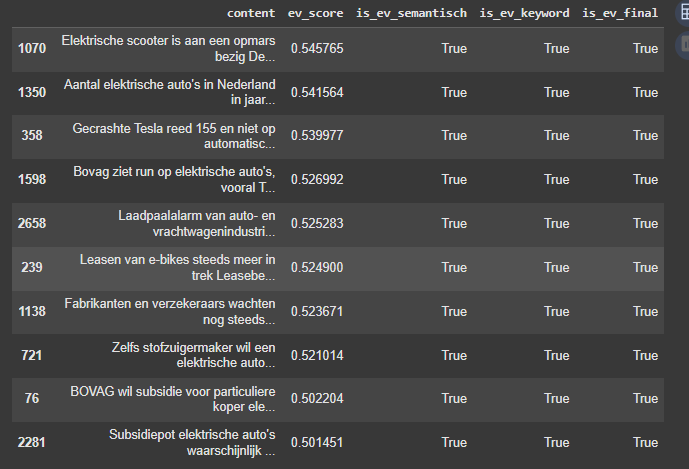

In [ ]:
from matplotlib import pyplot as plt
df_sample['ev_score'].plot(kind='hist', bins=20, title='ev_score') # Changed _df_4 to df_sample
plt.gca().spines[['top', 'right',]].set_visible(False)

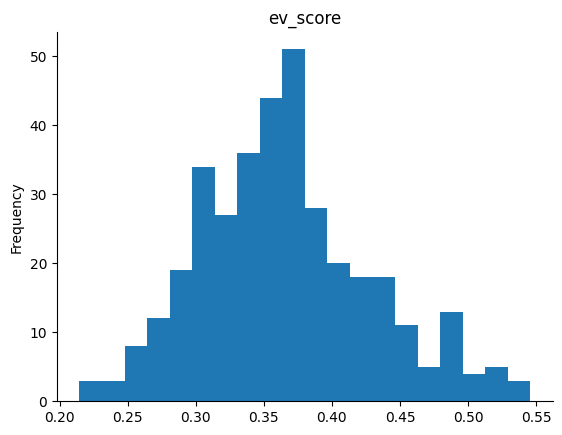

 ## Jina Embeddings V3

#### Superkleine batch draaien

In [52]:
import numpy as np

# Laad de embeddings
embeddings = np.load(r"E:\Nieuw dataset\ev_embeddings.npy")


print(embeddings.shape)  #

(3616, 1024)


In [53]:
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("jinaai/jina-embeddings-v3", trust_remote_code=True)




In [59]:
# Define a query specifically about electric cars
electric_cars_query = (
    "Nieuws over elektrische auto's",
    "Artikelen over laadpalen, elektrisch rijden, en subsidies voor elektrische voertuigen.",
    "Informatie over elektrische voertuigen, laadstations, en duurzame mobiliteit.",
    "Zoek naar nieuws over Tesla, en emissievrij vervoer.",
    "Elektrische auto's, accutechnologie, en energietransitie in het nieuws."
)

# Generate an embedding for the query
electric_cars_query_embedding = model.encode(electric_cars_query, task='retrieval.query').mean(axis=0)

# Calculate cosine similarity between the query embedding and the article embeddings
electric_cars_similarities = cosine_similarity([electric_cars_query_embedding], embeddings)[0]

# Ensure the length of electric_cars_similarities matches the subset of df_ev used for embeddings
df_ev = df_ev.iloc[:len(electric_cars_similarities)].copy()

# Add similarity scores to the subset DataFrame
df_ev['similarity'] = electric_cars_similarities

# Label articles as 'ev_related' based on a similarity threshold
similarity_threshold = 0.35
df_ev['ev_related'] = df_ev['similarity'] >= similarity_threshold

# Sort the DataFrame by similarity in descending order
sorted_articles = df_ev.sort_values(by='similarity', ascending=False).copy()




In [61]:
# Display the top 10 most relevant articles
print("Top 10 articles about electric cars:")
for idx, row in sorted_articles.head(100).iterrows():
    print(f"\nArticle {idx} similarity: {row['similarity']:.4f}")
    print(f"Title: {row['title']}")
    print(f"Description: {row['description']}")
    print(f"Content (snippet): {row['content'][:200]}...")
    print(f"URL: {row['url']}")
    # Print the related keywords for each article
    print(f"Related Keywords: {', '.join([kw for kw in ev_keywords if kw.lower() in row['combined_text'].lower()])}")


Top 10 articles about electric cars:

Article 11308 similarity: 0.5739
Title: Zuinige auto's met subsidie gewild over de grens
Description: Door de financiële voordelen bij aanschaf zijn ze goed tweedehands te verkopen aan andere landen.
Content (snippet): Zuinige auto's met subsidie gewild over de grens Veel elektrische auto's die zijn aangeschaft met subsidie, worden verkocht aan het buitenland. Daardoor wordt het lastiger om in Nederland de doelstell...
URL: https://nos.nl/artikel/2028957-zuinige-auto-s-met-subsidie-gewild-over-de-grens
Related Keywords: elektrische auto, tweedehands elektrische auto

Article 82024 similarity: 0.5600
Title: Meer geld voor elektrische laadpunten
Description: Het kabinet hoopt het elektrisch rijden aantrekkelijker te maken. De markt ervoor groeit amper.  
Content (snippet): Meer geld voor elektrische laadpunten Het kabinet trekt voor de komende twee jaar nog eens 1,5 miljoen euro uit voor laadpunten voor elektrische auto's. Eerder was er al 5,7 miljoe

In [62]:

# Save the sorted DataFrame with similarity scores to a CSV file
output_path = r"E:\Nieuw dataset\sorted_ev_articles_with_similarity.csv"
sorted_articles.to_csv(output_path, index=False, encoding='utf-8')
print(f"Sorted articles with similarity scores saved to: {output_path}")

Sorted articles with similarity scores saved to: E:\Nieuw dataset\sorted_ev_articles_with_similarity.csv


In [56]:


n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df_ev['cluster'] = kmeans.fit_predict(embeddings)
df_ev[['content', 'cluster']].head(10)



,content,cluster
7,Verkoop nieuwe auto's stevent af op laagtereco...,5
74,De stroom 02/01 'Vermiste Amerikaan dood gevon...,2
305,Wind en hitte bedreigen bosbrandgebied Austral...,9
867,Hoe gegijzelden buiten schot bleven in Parijs ...,9
1075,Stroomstoring Rotterdam automatisch opgelost V...,8
1102,Wetenschappers waarschuwen voor kunstmatige in...,6
1565,Stroomstoring Velsen-Noord weer voorbij In een...,3
1921,'Duurzaam ondernemen zal winnen' Steeds meer b...,1
2264,"Halep, grandslamkampioene van de toekomst Ze i...",4
2539,"Het dunste, lichtste én sterkste materiaal ooi...",8


In [63]:
# Load the sorted DataFrame from the specified path
sorted_df = pd.read_csv(r"E:\Nieuw dataset\sorted_ev_articles.csv") 


Gemiddeld aantal EV-gerelateerde artikelen per maand: 27.39


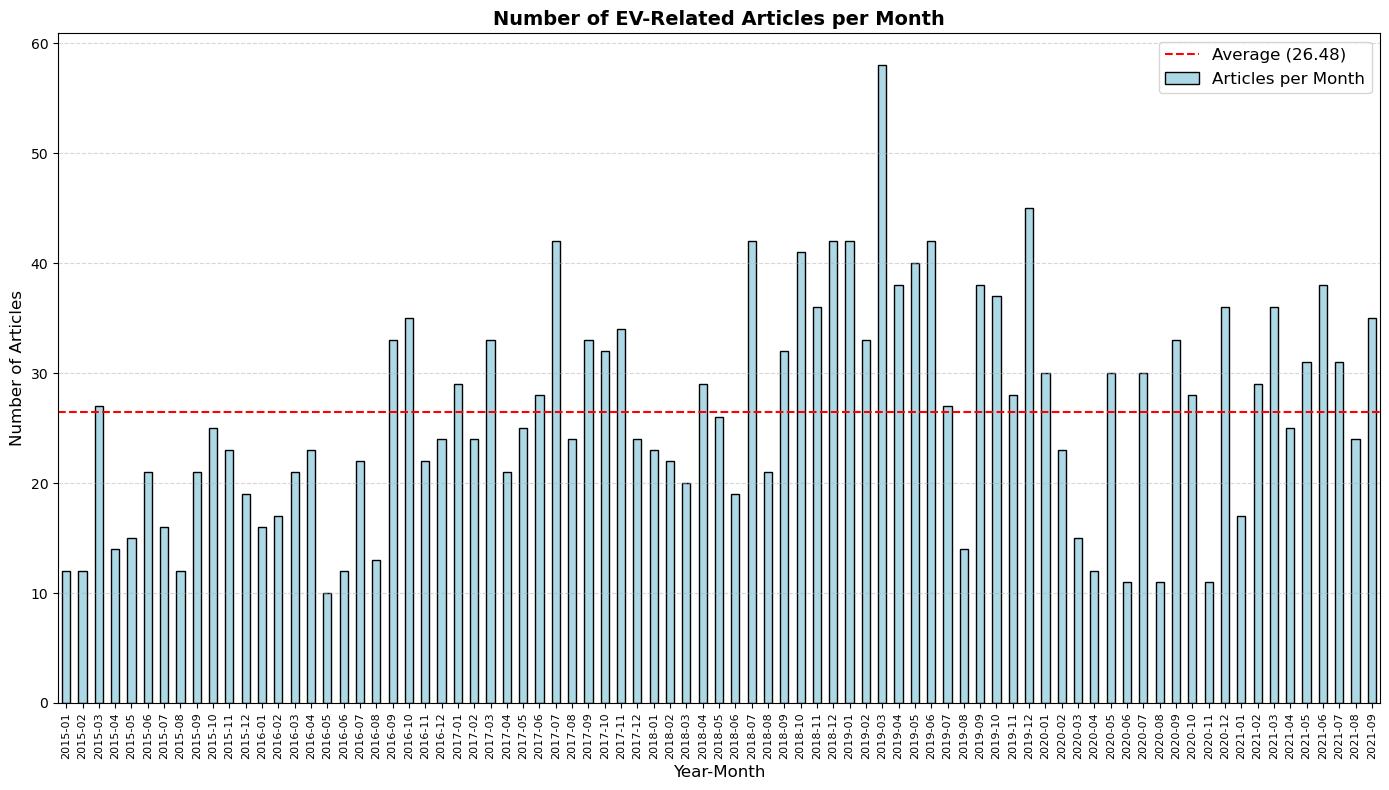

Totaal aantal artikelen: 2145


In [64]:
# Gemiddeld per maand
average_ev_articles_per_month = ev_articles_per_year.sum() / (len(ev_articles_per_year) * 12)
print(f"Gemiddeld aantal EV-gerelateerde artikelen per maand: {average_ev_articles_per_month:.2f}")

# Ensure 'published_time' is in datetime format
sorted_df['published_time'] = pd.to_datetime(sorted_df['published_time'], errors='coerce')

# Extract year and month from 'published_time'
sorted_df['year_month'] = sorted_df['published_time'].dt.to_period('M')

# Count the number of articles per month
articles_per_month = sorted_df['year_month'].value_counts().sort_index()

# Calculate the average number of articles per month
average_articles_per_month = articles_per_month.mean()

# Plot the data
plt.figure(figsize=(14, 8))
articles_per_month.plot(kind='bar', color='lightblue', edgecolor='black', label="Articles per Month")

# Add a horizontal line for the average
plt.axhline(y=average_articles_per_month, color='red', linestyle='--', label=f"Average ({average_articles_per_month:.2f})")

# Add labels, title, and formatting
plt.title("Number of EV-Related Articles per Month", fontsize=14, fontweight="bold")
plt.xlabel("Year-Month", fontsize=12)
plt.ylabel("Number of Articles", fontsize=12)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle="--", alpha=0.5)
plt.legend(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()
# Print the total number of articles
total_articles = len(sorted_df)
print(f"Totaal aantal artikelen: {total_articles}")


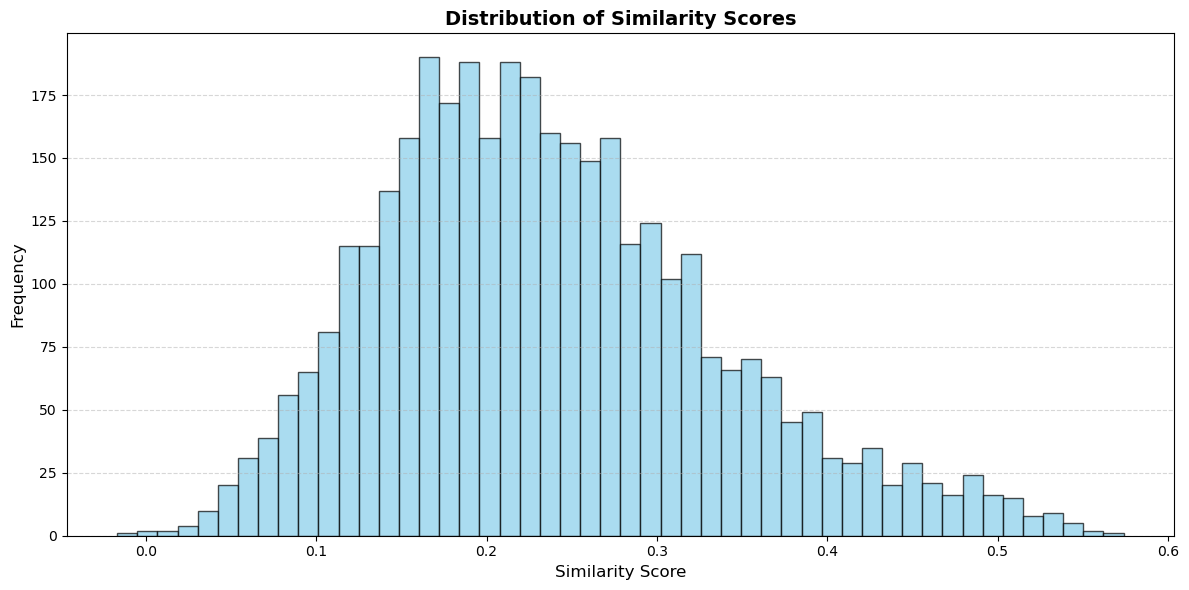

In [65]:
import matplotlib.pyplot as plt

# Plot similarity scores
plt.figure(figsize=(12, 6))
plt.hist(electric_cars_similarities, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Distribution of Similarity Scores", fontsize=14, fontweight="bold")
plt.xlabel("Similarity Score", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis='y', linestyle="--", alpha=0.5)
plt.tight_layout()

# Show the plot
plt.show()

In [66]:
# Calculate the average similarity score for the top 10 articles
top_10_articles = sorted_articles.head(10)
average_similarity_top_10 = top_10_articles['similarity'].mean()

# Print the titles and similarity scores of the top 10 articles
print("Top 10 Articles with Average Similarity:")
for idx, row in top_10_articles.iterrows():
    print(f"Title: {row['title']}")
    print(f"Similarity Score: {row['similarity']:.4f}")
    print(f"URL: {row['url']}\n")

# Print the average similarity score
print(f"Average Similarity Score of Top 10 Articles: {average_similarity_top_10:.4f}")

Top 10 Articles with Average Similarity:
Title: Zuinige auto's met subsidie gewild over de grens
Similarity Score: 0.5739
URL: https://nos.nl/artikel/2028957-zuinige-auto-s-met-subsidie-gewild-over-de-grens

Title: Meer geld voor elektrische laadpunten
Similarity Score: 0.5600
URL: https://nos.nl/artikel/2146892-meer-geld-voor-elektrische-laadpunten

Title: Infographic: slaan we straks groene energie op in onze auto's?
Similarity Score: 0.5509
URL: https://nos.nl/op3/artikel/2197513-infographic-slaan-we-straks-groene-energie-op-in-onze-auto-s

Title: Nederlandse elektrische auto ook in Duitsland aan de paal
Similarity Score: 0.5475
URL: https://nos.nl/artikel/2144267-nederlandse-elektrische-auto-ook-in-duitsland-aan-de-paal

Title: Nederland koploper groei volledig elektrische auto's
Similarity Score: 0.5473
URL: https://nos.nl/artikel/2214845-nederland-koploper-groei-volledig-elektrische-auto-s

Title: Aantal stekkerauto's is verdubbeld
Similarity Score: 0.5436
URL: https://nos.nl/art

In [68]:
# Get the top 10 articles with the lowest similarity scores
top_10_lowest_similarity = sorted_articles.nsmallest(100, 'similarity')

# Print the details of the top 10 lowest similarity articles
print("Top 10 Articles with the Lowest Similarity Scores:")
for idx, row in top_10_lowest_similarity.iterrows():
    print(f"\nArticle {idx} similarity: {row['similarity']:.4f}")
    print(f"Title: {row['title']}")
    print(f"Description: {row['description']}")
    print(f"Content (snippet): {row['content'][:200]}...")
    print(f"URL: {row['url']}")


Top 10 Articles with the Lowest Similarity Scores:

Article 195822 similarity: -0.0168
Title: Horeca-ondernemer voor de rechter: 'Thuis meer risico op besmetting'
Description: In een kort geding eisen zeker 68 horecaondernemers onmiddellijke heropening van de horeca. De rechter doet vanmiddag uitspraak. 
Content (snippet): Horeca-ondernemer voor de rechter: 'Thuis meer risico op besmetting' De rechtbank in Den Haag doet vanmiddag om 16.00 uur uitspraak in het door meerdere horecaondernemers aangespannen kort geding. De ...
URL: https://nos.nl/artikel/2353064-horeca-ondernemer-voor-de-rechter-thuis-meer-risico-op-besmetting

Article 232125 similarity: 0.0036
Title: Onderduikershol op de Veluwe na 78 jaar gevonden
Description: De 83-jarige Jits van Straten zat daar als 5-jarige jongen ondergedoken in de Tweede Wereldoorlog. Hij was bij de opgravingen.
Content (snippet): Onderduikershol op de Veluwe na 78 jaar gevonden Bij archeologische opgravingen op de Veluwe is waarschijnlijk een onde

c:\Users\dylan\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dylan\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


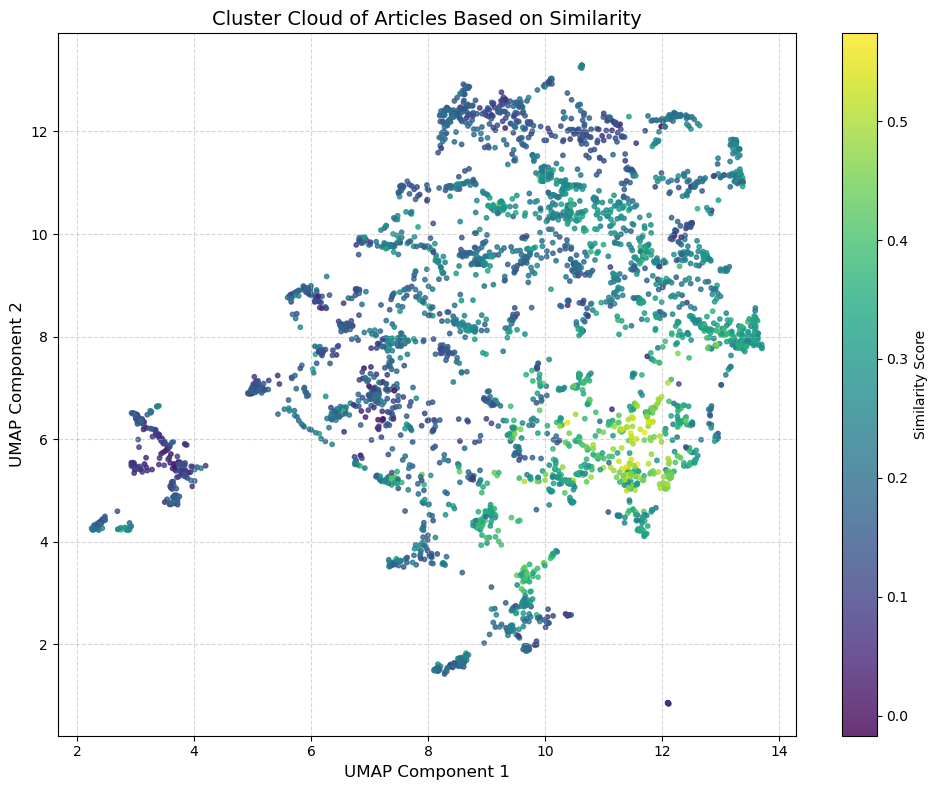

In [69]:
import umap  # Import the UMAP library for dimensionality reduction
import numpy as np  # Import NumPy for numerical operations
import matplotlib.pyplot as plt  # Import Matplotlib for plotting

# Reduce embeddings to 2D using UMAP
# UMAP is used to reduce the high-dimensional embeddings into 2D for visualization
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42)
embedding_2d = reducer.fit_transform(embeddings)  # Perform the dimensionality reduction

# Create a scatter plot with similarity scores as colors
plt.figure(figsize=(10, 8))  # Set the figure size for the plot
scatter = plt.scatter(
    embedding_2d[:, 0],  # Use the first UMAP component for the x-axis
    embedding_2d[:, 1],  # Use the second UMAP component for the y-axis
    c=electric_cars_similarities,  # Color the points based on similarity scores
    cmap="viridis",  # Use the 'viridis' colormap for coloring
    s=10,  # Set the size of the points
    alpha=0.8  # Set the transparency of the points
)

# Add a color bar to indicate similarity scores
plt.colorbar(scatter, label="Similarity Score")  # Add a color bar with a label

# Add title and axis labels to the plot
plt.title("Cluster Cloud of Articles Based on Similarity", fontsize=14)  # Set the plot title
plt.xlabel("UMAP Component 1", fontsize=12)  # Label for the x-axis
plt.ylabel("UMAP Component 2", fontsize=12)  # Label for the y-axis

# Add grid lines to the plot for better readability
plt.grid(True, linestyle="--", alpha=0.5)  # Add a grid with dashed lines and some transparency

# Adjust the layout to ensure everything fits well
plt.tight_layout()

# Show the plot
plt.show()  # Display the scatter plot

De bovenstaande visualisatie toont een 2D-projectie van alle nieuwsartikelen over elektrische voertuigen, waarbij de positionering is gebaseerd op tekstuele overeenkomst tussen artikelen (via embeddings + cosine similarity). De kleuren representeren de similarity score t.o.v. de EV-query: hoe groener/geel, hoe relevanter het artikel is voor elektrische voertuigen.

Clusters vormen inhoudelijke thema’s – Artikelen die inhoudelijk sterk op elkaar lijken (bijvoorbeeld subsidies of laadpalen) liggen dicht bij elkaar.

Groen/gele zones zijn het meest relevant – Deze bevatten waarschijnlijk goed passende artikelen voor EV-analyse.

Paarse/blauwe gebieden zijn minder gerelateerd – Dit kan wijzen op ruis of bredere maatschappelijke thema’s met zwakke link naar EV's.

In [ ]:
from transformers import pipeline
import pandas as pd


# Laad de sentiment-analyse pipeline (werkt direct)
pipe = pipeline("text-classification", model="DTAI-KULeuven/robbert-v2-dutch-sentiment")


In [ ]:
ev_sentiment = sorted_df.copy()

# Sentimentfunctie die alle scores teruggeeft
def predict_sentiment_full(text):
    results = pipe(text, truncation=True)
    scores = {res['label']: res['score'] for res in results}
    best_label = max(scores, key=scores.get)
    return best_label, scores.get('positive', 0), scores.get('neutral', 0), scores.get('negative', 0)

# Pas sentiment toe op alle rijen
results = ev_sentiment['combined_text'].apply(predict_sentiment_full)

# Voeg kolommen toe
ev_sentiment['sentiment_label'] = results.apply(lambda x: x[0])
ev_sentiment['positive_score'] = results.apply(lambda x: x[1])
ev_sentiment['neutral_score'] = results.apply(lambda x: x[2])
ev_sentiment['negative_score'] = results.apply(lambda x: x[3])
# Apply sentiment analysis with a progress bar
results = []
for text in tqdm(ev_sentiment['combined_text'], desc="Processing Sentiment Analysis"):
    results.append(predict_sentiment(text))

# Convert results to DataFrame columns
ev_sentiment['sentiment_label'] = [res[0] for res in results]
ev_sentiment['sentiment_score'] = [res[1] for res in results]

# Optioneel tonen
from IPython.display import display
display(ev_sentiment[['title', 'url', 'sentiment_label', 'positive_score', 'neutral_score', 'negative_score']])


# Opslaan
ev_sentiment.to_csv("ev_subset_with_sentiment.csv", index=False, encoding="utf-8")

In [74]:
from tqdm import tqdm


# # Laad je dataframe
# df_sorted = pd.read_csv(r"E:\Nieuw dataset\sorted_ev_articles.csv")

# Combineer tekstvelden tot één kolom voor sentimentanalyse
sorted_df['combined_text'] 

# Pak een subset van 25 artikelen
df_subset =sorted_df.copy()

# Functie om sentimentlabel en score te halen via pipeline
def predict_sentiment(text):
    result = pipe(text, truncation=True)[0]
    return result['label'], result['score']

# Pas toe op de subset
results = df_subset['combined_text'].apply(predict_sentiment)
df_subset['sentiment_label'] = results.apply(lambda x: x[0])
df_subset['sentiment_score'] = results.apply(lambda x: x[1])

# Apply sentiment analysis with a progress bar
results = []
for text in tqdm(df_subset['combined_text'], desc="Processing Sentiment Analysis"):
    results.append(predict_sentiment(text))

# Convert results to DataFrame columns
df_subset['sentiment_label'] = [res[0] for res in results]
df_subset['sentiment_score'] = [res[1] for res in results]

# Opslaan
#df_subset.to_csv("ev_subset_with_sentiment.csv", index=False, encoding="utf-8")




display(df_subset[['title', 'url', 'sentiment_label', 'sentiment_score']])



Processing Sentiment Analysis: 100%|██████████| 2145/2145 [16:48<00:00,  2.13it/s]


,title,url,sentiment_label,sentiment_score
0,Zuinige auto's met subsidie gewild over de grens,https://nos.nl/artikel/2028957-zuinige-auto-s-...,Negative,0.504026
1,Tien procent van nieuwe auto's heeft stekker,https://nos.nl/artikel/2080280-tien-procent-va...,Positive,0.995917
2,Plan voor veel meer laadpalen in parkeergarages,https://nos.nl/artikel/2371152-plan-voor-veel-...,Positive,0.998279
3,Aantal stekkerauto's is verdubbeld,https://nos.nl/artikel/2101496-aantal-stekkera...,Positive,0.501588
4,Infographic: slaan we straks groene energie op...,https://nos.nl/op3/artikel/2197513-infographic...,Positive,0.775774
...,...,...,...,...
2140,"Oud, ouder, oudst: dertigers heersen in het to...",https://nos.nl/artikel/2181331-oud-ouder-oudst...,Positive,0.999176
2141,Woede en ongeloof over trage zoektocht na zeer...,https://nos.nl/artikel/2230099-woede-en-ongelo...,Positive,0.855922
2142,Viroloog Koopmans: kerk op Urk speelt 'Russisc...,https://nos.nl/artikel/2373944-viroloog-koopma...,Negative,0.990834
2143,Na bloedbad op boot bij Suriname opnieuw visse...,https://nos.nl/artikel/2230202-na-bloedbad-op-...,Positive,0.790580


In [ ]:
# Opslaan
df_subset.to_csv("ev_subset_with_sentiment, index=False, encoding="utf-8")

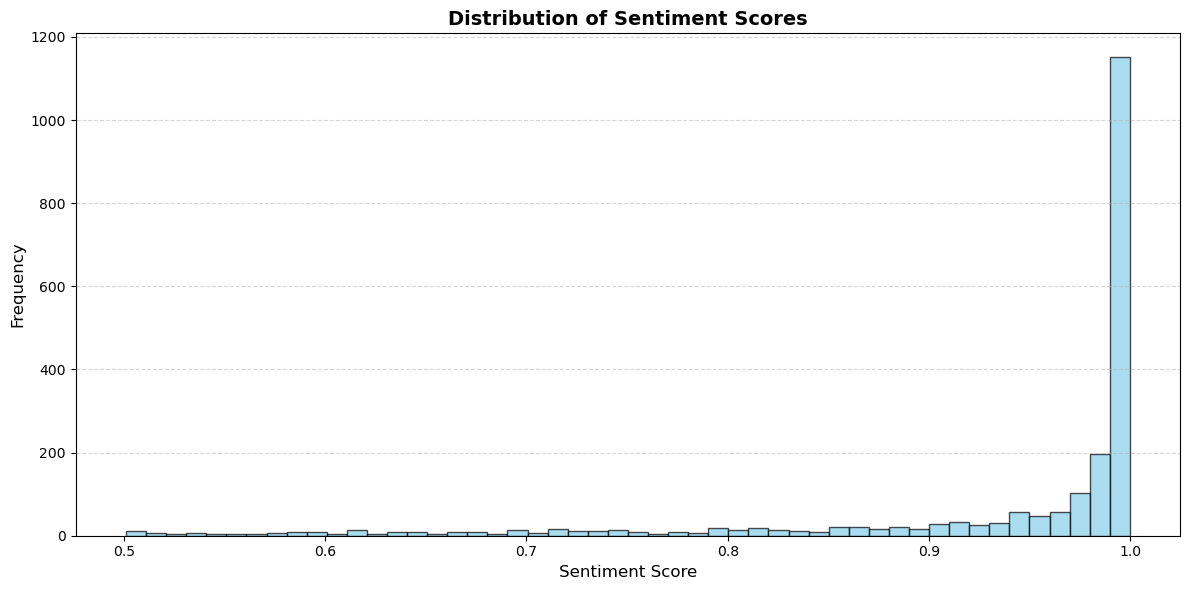

In [79]:
import pandas as pd

import matplotlib.pyplot as plt

# # Load the dataset
# file_path = r"E:\Nieuw dataset\Total_EV_with_sentiment.csv"
# df = pd.read_csv(file_path)

# Ensure sentiment_score column is numeric
#df_subset['sentiment_score'] = pd.to_numeric(downcast=['sentiment_score'], errors='coerce')

# Plot the sentiment scores
plt.figure(figsize=(12, 6))
plt.hist(df_subset['sentiment_score'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Distribution of Sentiment Scores", fontsize=14, fontweight="bold")
plt.xlabel("Sentiment Score", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis='y', linestyle="--", alpha=0.5)
plt.tight_layout()

# Show the plot
plt.show()

oud: 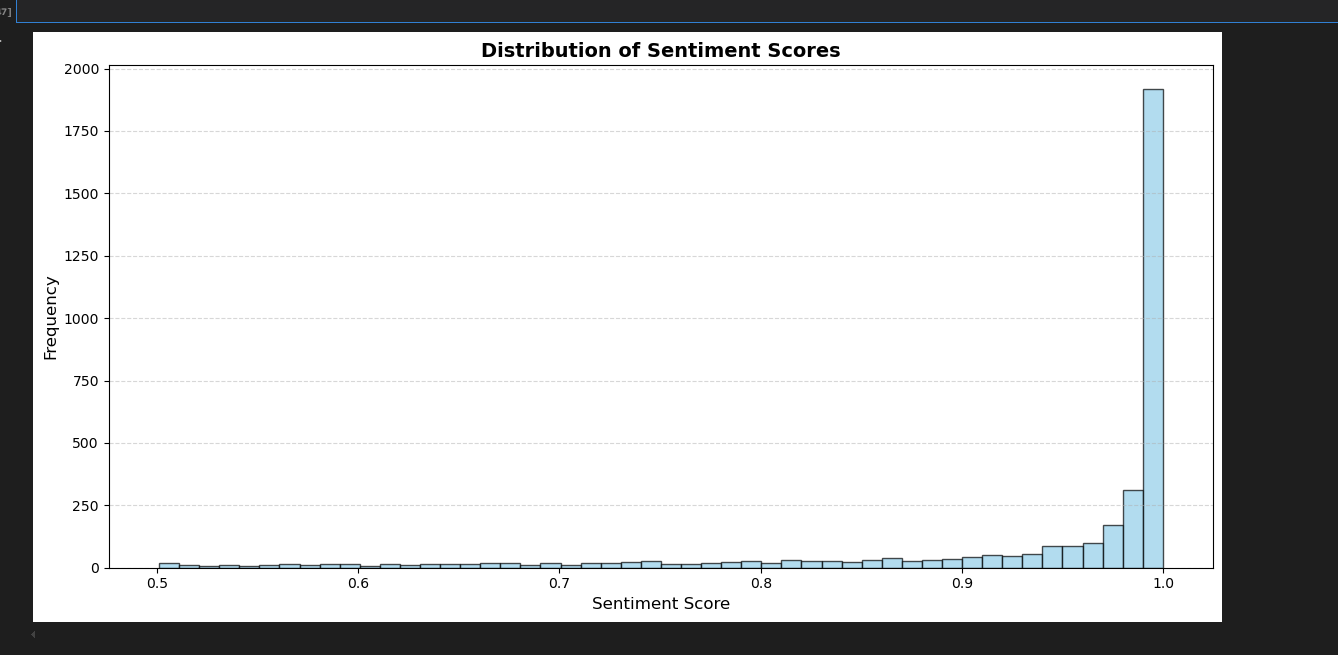

In [86]:
# Zorg dat 'published_time' in datetime staat
df_subset['published_time'] = pd.to_datetime(df_subset['published_time'], errors='coerce')

# Maak 'year_month' kolom
df_subset['year_month'] = df_subset['published_time'].dt.to_period('M')

# Verzamel unieke maanden in de dataset
all_months = df_subset['year_month'].dropna().unique()

# Filter rijen met geldige sentiment_score
valid_sentiment = df_subset[df_subset['sentiment_score'].notna()]
months_with_sentiment = valid_sentiment['year_month'].dropna().unique()

# Zoek ontbrekende maanden
missing_months = set(all_months) - set(months_with_sentiment)

# Resultaat tonen
if not missing_months:
    print("✅ Alle maanden in df_subset hebben sentiment scores.")
else:
    print("⚠️ De volgende maanden in df_subset missen sentiment scores:")
    print(sorted(missing_months))



✅ Alle maanden in df_subset hebben sentiment scores.


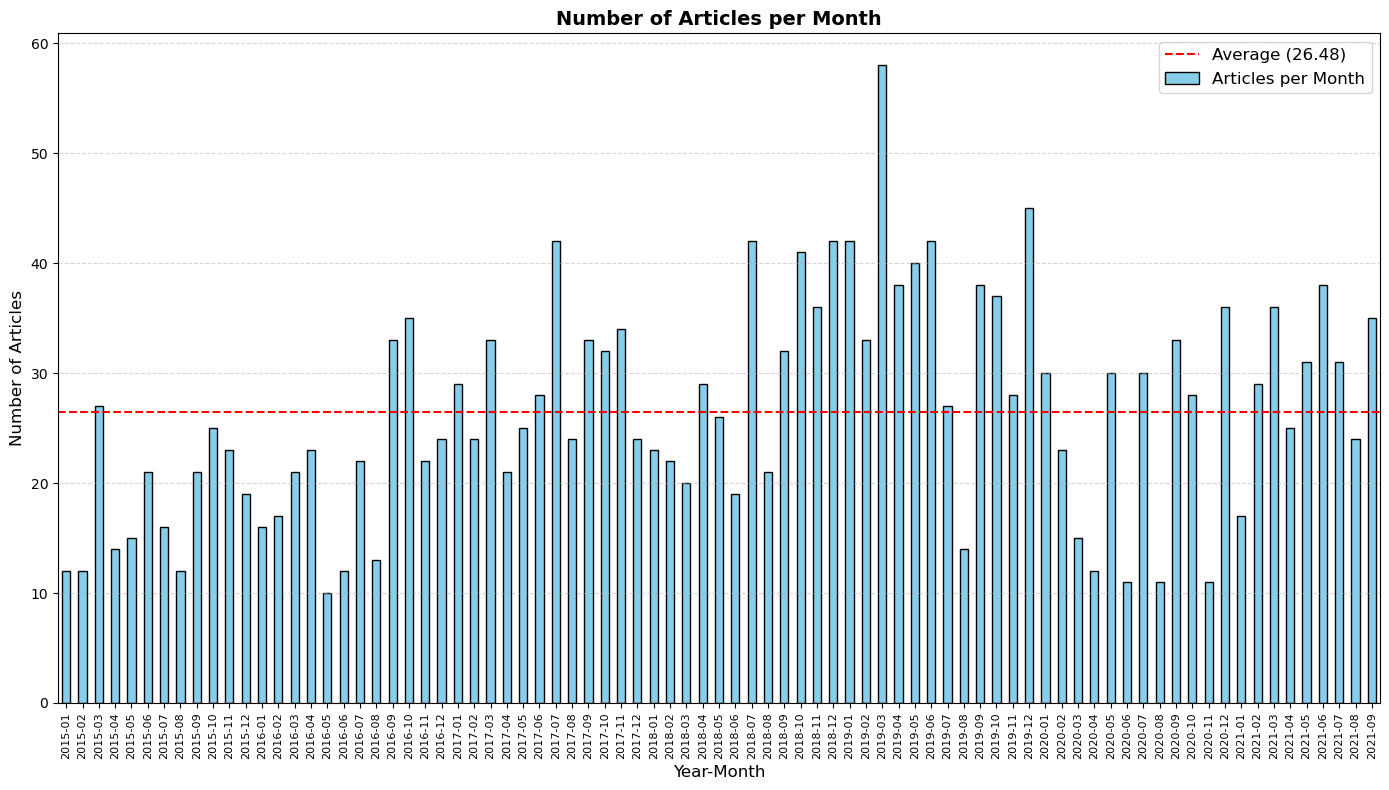

In [82]:
import matplotlib.pyplot as plt
import pandas as pd

# Zorg dat 'published_time' in datetime-formaat staat
df_subset['published_time'] = pd.to_datetime(df_subset['published_time'], errors='coerce')

# Maak een 'year_month' kolom
df_subset['year_month'] = df_subset['published_time'].dt.to_period('M')

# Tel artikelen per maand
articles_per_month = df_subset['year_month'].value_counts().sort_index()

# Gemiddeld aantal artikelen per maand
average_articles_per_month = articles_per_month.mean()

# Plot
plt.figure(figsize=(14, 8))
articles_per_month.plot(kind='bar', color='skyblue', edgecolor='black', label="Articles per Month")
plt.axhline(y=average_articles_per_month, color='red', linestyle='--', label=f"Average ({average_articles_per_month:.2f})")
plt.title("Number of Articles per Month", fontsize=14, fontweight="bold")
plt.xlabel("Year-Month", fontsize=12)
plt.ylabel("Number of Articles", fontsize=12)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle="--", alpha=0.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


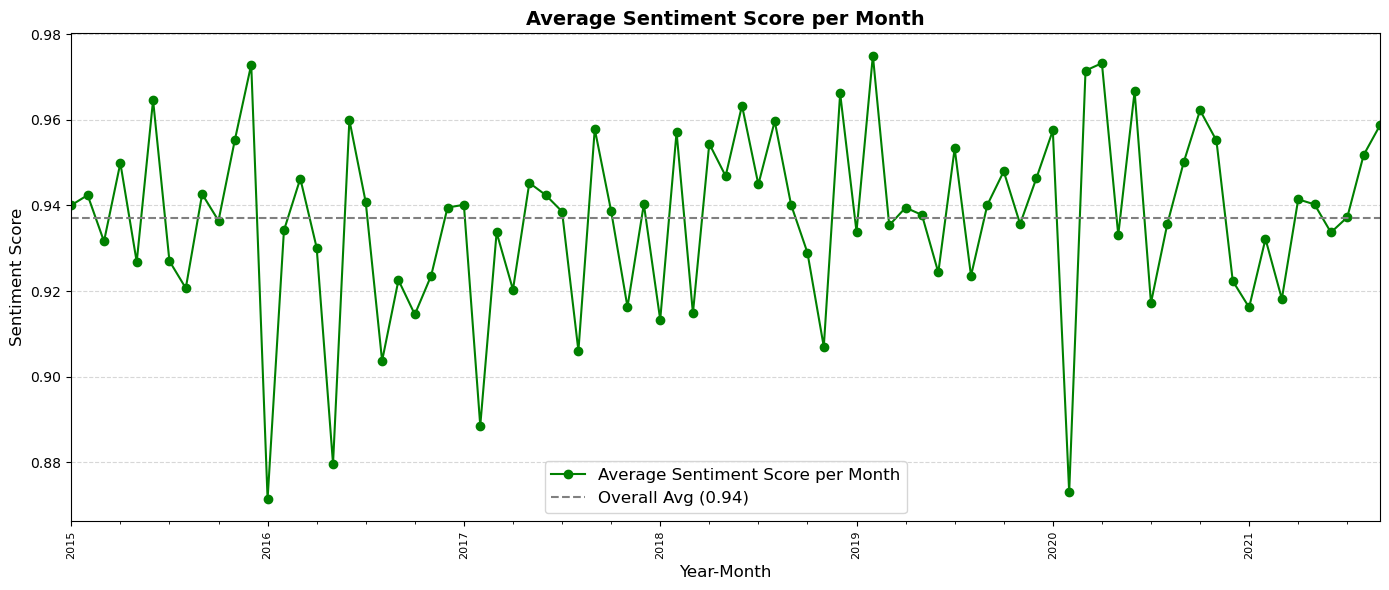

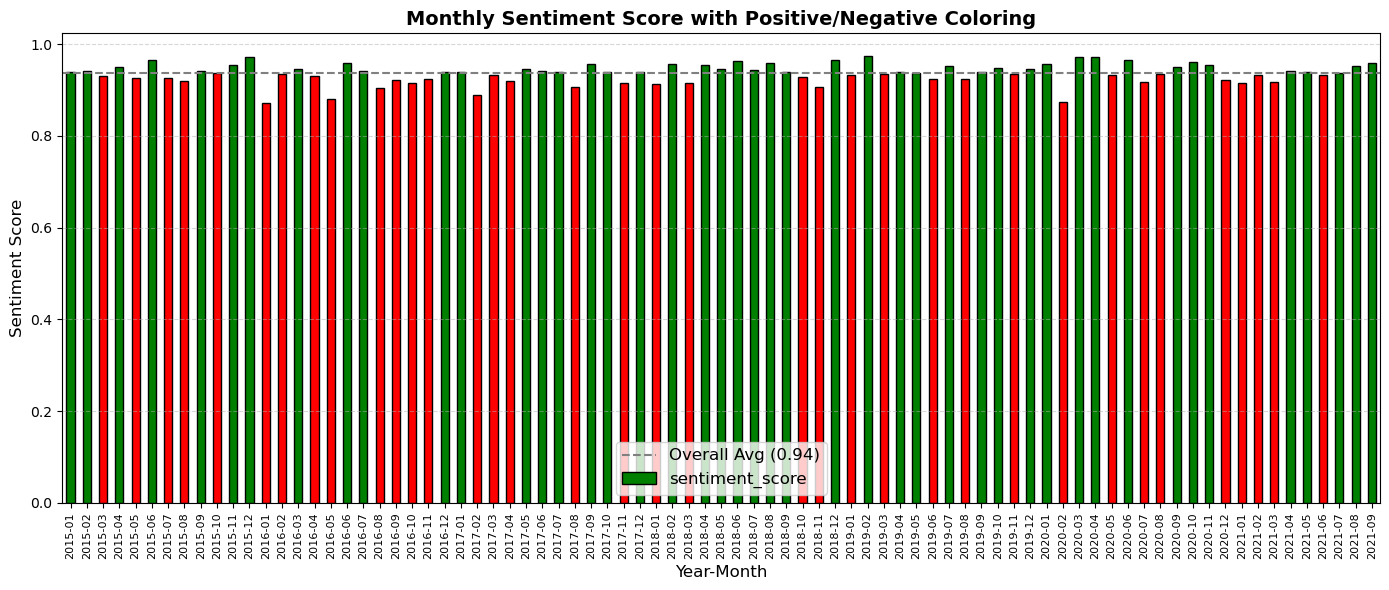

In [89]:
import matplotlib.pyplot as plt

# Controleer of sentiment_score en year_month bestaan
if 'sentiment_score' in df_subset.columns and 'year_month' in df_subset.columns:

    # Bereken gemiddeld sentiment per maand
    monthly_avg = df_subset.groupby('year_month')['sentiment_score'].mean()

    # Bereken overall gemiddelde sentiment
    overall_avg = df_subset['sentiment_score'].mean()

    # ===== Plot 1: Lijnplot met gewogen gemiddelde =====
    plt.figure(figsize=(14, 6))
    monthly_avg.plot(marker='o', linestyle='-', color='green', label='Average Sentiment Score per Month')
    plt.axhline(y=overall_avg, color='gray', linestyle='--', label=f'Overall Avg ({overall_avg:.2f})')
    plt.title("Average Sentiment Score per Month", fontsize=14, fontweight="bold")
    plt.xlabel("Year-Month", fontsize=12)
    plt.ylabel("Sentiment Score", fontsize=12)
    plt.xticks(rotation=90, fontsize=8)
    plt.yticks(fontsize=10)
    plt.grid(axis='y', linestyle="--", alpha=0.5)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

    # ===== Plot 2: Staafdiagram met kleuren =====
    colors = ['green' if score >= overall_avg else 'red' for score in monthly_avg]

    plt.figure(figsize=(14, 6))
    monthly_avg.plot(kind='bar', color=colors, edgecolor='black')
    plt.axhline(y=overall_avg, color='gray', linestyle='--', label=f'Overall Avg ({overall_avg:.2f})')
    plt.title("Monthly Sentiment Score with Positive/Negative Coloring", fontsize=14, fontweight="bold")
    plt.xlabel("Year-Month", fontsize=12)
    plt.ylabel("Sentiment Score", fontsize=12)
    plt.xticks(rotation=90, fontsize=8)
    plt.yticks(fontsize=10)
    plt.grid(axis='y', linestyle="--", alpha=0.5)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

else:
    print("Zorg dat de kolommen 'sentiment_score' en 'year_month' aanwezig zijn in df_subset.")



In [91]:
# Zet published_time om naar datetime
df_subset['published_time'] = pd.to_datetime(df_subset['published_time'], errors='coerce')

# Maak een 'year_month' kolom in 'YYYY/MM'-formaat
df_subset['year_month'] = df_subset['published_time'].dt.strftime('%Y/%m')

# Bereken gemiddeld sentiment per maand
avg_sentiment_per_month = (
    df_subset.groupby('year_month')['sentiment_score']
    .mean()
    .reset_index()
)

# Kolommen hernoemen
avg_sentiment_per_month.columns = ['Year-Month', 'Average Sentiment Score']

# Sla op naar CSV
avg_sentiment_per_month.to_csv(
    r"E:\Nieuw dataset\Dutch news articles 2015-2025 NOS.nl\average_sentiment_per_month.csv",
    index=False,
    encoding='utf-8'
)

print("✅ Bestand 'average_sentiment_per_month.csv' succesvol opgeslagen.")


✅ Bestand 'average_sentiment_per_month.csv' succesvol opgeslagen.
